## INRIA Pedestrian Data

Data from http://pascal.inrialpes.fr/data/human/.

In [1]:
from glob import glob
import os
import h5py
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using Theano backend.


In [1]:
import keras

Using Theano backend.


In [2]:
keras.__version__

'1.2.1'

In [2]:
# paths to the model weights file
weights_path = '../vgg16_weights.h5'
top_model_weights_path = 'inria_bottleneck_fc_model.h5'

# image dimensions
img_width, img_height = 150, 150

# data directories
train_data_dir = '../data/inria/train'
test_data_dir = '../data/inria/test'

# number of training/test samples
n_pos_train_samples = len(glob(train_data_dir + '/pos/*'))
n_neg_train_samples = len(glob(train_data_dir + '/neg/*'))
n_pos_test_samples = len(glob(test_data_dir + '/pos/*'))
n_neg_test_samples = len(glob(test_data_dir + '/neg/*'))
n_train_samples = n_pos_train_samples + n_neg_train_samples
n_test_samples = n_pos_test_samples + n_neg_test_samples

In [3]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [4]:
# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [5]:
# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # ommit the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('model loaded')

model loaded


In [6]:
datagen = ImageDataGenerator(rescale=1./255)

# generate training features
generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode=None,
        shuffle=False)

bottleneck_features_train = model.predict_generator(generator, n_train_samples)
np.save(open('inria_bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 1832 images belonging to 2 classes.


In [9]:
# generate validation features
generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode=None,
        shuffle=False)

bottleneck_features_test = model.predict_generator(generator, n_test_samples)
np.save(open('inria_bottleneck_features_validation.npy', 'wb'), bottleneck_features_test)

Found 741 images belonging to 2 classes.


In [5]:
from keras import metrics, optimizers
from sklearn.utils import class_weight

# number of epochs
n_epoch = 100

train_data = np.load(open('inria_bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * n_neg_train_samples + [1] * n_pos_train_samples)

test_data = np.load(open('inria_bottleneck_features_validation.npy', 'rb'))
test_labels = np.array([0] * n_neg_test_samples + [1] * n_pos_test_samples)

class_weight = class_weight.compute_class_weight(
    'balanced', np.unique(train_labels), train_labels)

In [6]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['mae', 'acc'])

history = model.fit(train_data, train_labels,
                    nb_epoch=n_epoch, batch_size=16,
                    validation_data=(test_data, test_labels),
                    class_weight=class_weight)

model.save_weights(top_model_weights_path)

Train on 1832 samples, validate on 741 samples
Epoch 1/100
1832/1832 [==============================] - 1s - loss: 0.5719 - mean_absolute_error: 0.3878 - acc: 0.7118 - val_loss: 0.4738 - val_mean_absolute_error: 0.3535 - val_acc: 0.7773
Epoch 2/100
1832/1832 [==============================] - 1s - loss: 0.4248 - mean_absolute_error: 0.3089 - acc: 0.8199 - val_loss: 0.3875 - val_mean_absolute_error: 0.2980 - val_acc: 0.8583
Epoch 3/100
1832/1832 [==============================] - 1s - loss: 0.3653 - mean_absolute_error: 0.2667 - acc: 0.8433 - val_loss: 0.3462 - val_mean_absolute_error: 0.2599 - val_acc: 0.8664
Epoch 4/100
1832/1832 [==============================] - 1s - loss: 0.3276 - mean_absolute_error: 0.2357 - acc: 0.8810 - val_loss: 0.3150 - val_mean_absolute_error: 0.2365 - val_acc: 0.8745
Epoch 5/100
1832/1832 [==============================] - 1s - loss: 0.3003 - mean_absolute_error: 0.2168 - acc: 0.8843 - val_loss: 0.3012 - val_mean_absolute_error: 0.2223 - val_acc: 0.8799
Epo

In [7]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'mean_absolute_error', 'acc', 'val_mean_absolute_error', 'val_acc'])

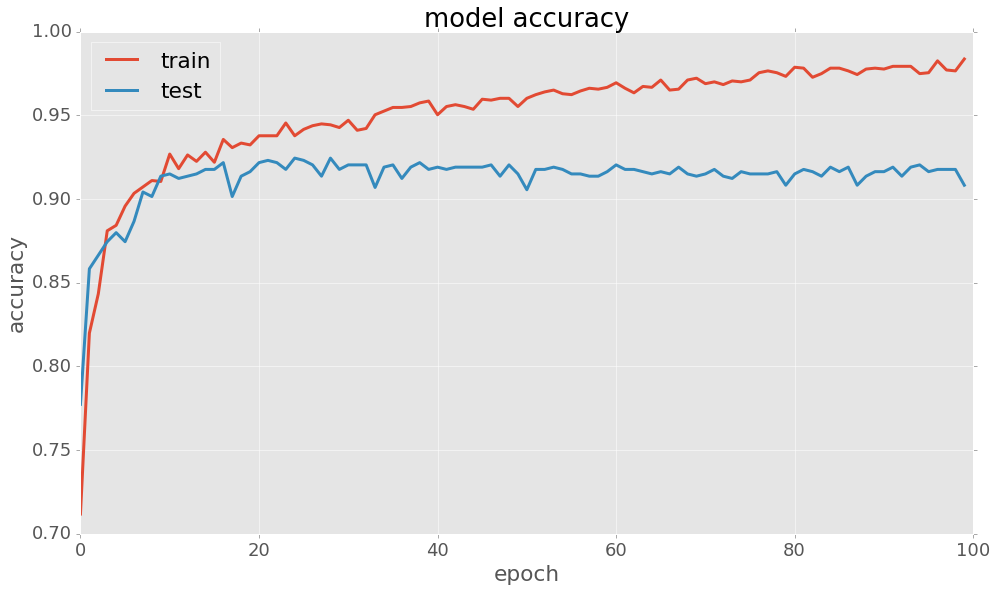

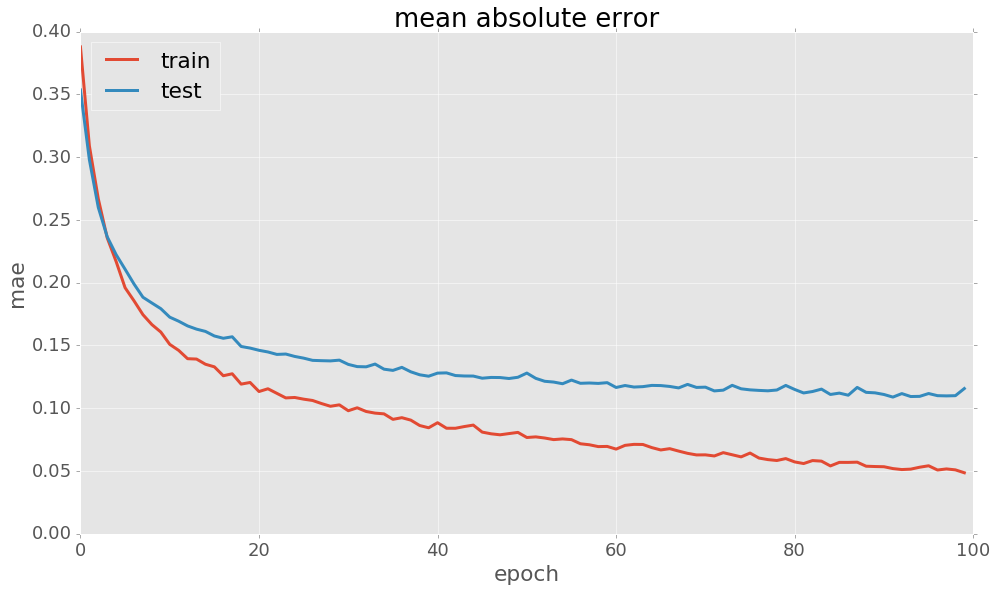

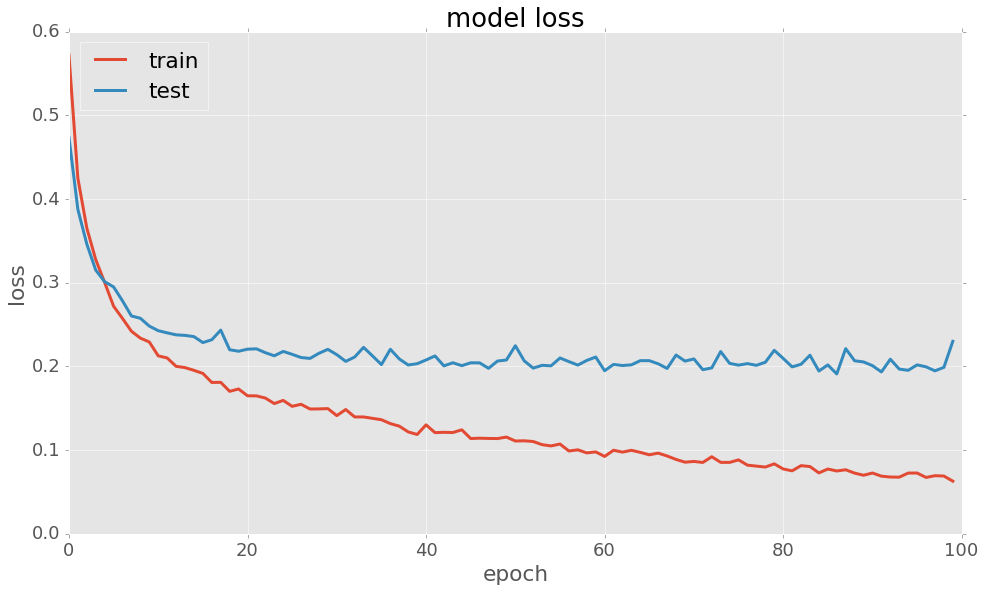

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth': 3})


# accuracy
plt.figure(figsize=(16,9))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# accuracy
plt.figure(figsize=(16,9))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# loss
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Fine-tuning top conv layer

In [19]:
from keras import optimizers

In [9]:
# paths to the model weights file
weights_path = '../vgg16_weights.h5'
top_model_weights_path = 'inria_bottleneck_fc_model.h5'

# image dimensions
img_width, img_height = 150, 150

# data directories
train_data_dir = '../data/inria/train'
test_data_dir = '../data/inria/test'

# number of training/test samples
n_pos_train_samples = len(glob(train_data_dir + '/pos/*'))
n_neg_train_samples = len(glob(train_data_dir + '/neg/*'))
n_pos_test_samples = len(glob(test_data_dir + '/pos/*'))
n_neg_test_samples = len(glob(test_data_dir + '/neg/*'))
n_train_samples = n_pos_train_samples + n_neg_train_samples
n_test_samples = n_pos_test_samples + n_neg_test_samples

In [10]:
# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [11]:
# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

Model loaded.


In [12]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['mae', 'acc'])

In [13]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='binary')

Found 1832 images belonging to 2 classes.
Found 741 images belonging to 2 classes.


In [ ]:
# fine-tune the model
model.fit_generator(
        train_generator,
        samples_per_epoch=n_train_samples,
        nb_epoch=20,
        validation_data=validation_generator,
        nb_val_samples=n_test_samples,
        class_weight=class_weight)

Epoch 1/20
 112/1832 [>.............................] - ETA: 480s - loss: 0.0806 - mean_absolute_error: 0.0638 - acc: 0.9732